In [12]:
CN_list

[1, 2]

delta_Tlist:  [1, 2, 3]
(3, 3)


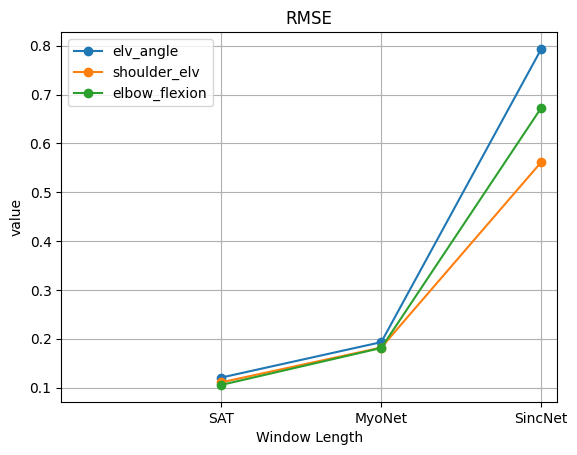

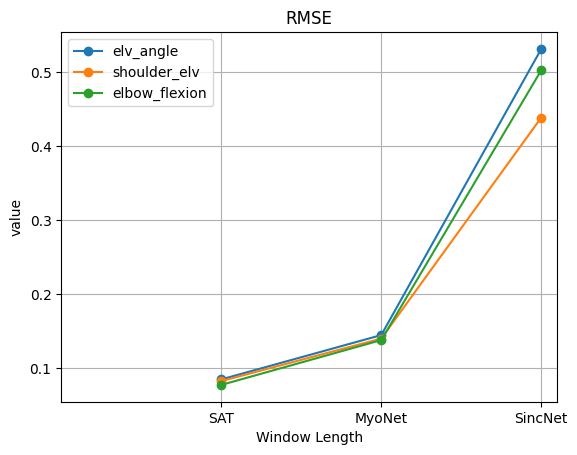

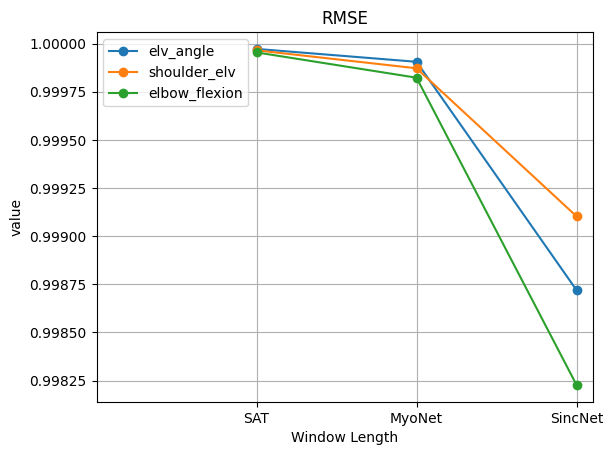

In [14]:
# Compare Net
# 多个文件夹
from datetime import datetime
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from utils.tools import make_dir

from utils.tools import calMeans, plot_func, plot_func_ticks
    

CN_list = []

# 自定义排序函数：提取倒数第二个数字
def sort_key(folder_name):
    # 假设文件夹名称格式为 MJ_PCA_1_256，提取倒数第二个数字
    parts = folder_name.split('_')  # 按下划线分割
    if len(parts) >= 2 and parts[-1].isdigit():  # 确保倒数第二个部分是数字
        CN_list.append(int(parts[-1]))
        return int(parts[-1])  # 返回倒数第二个数字作为排序键
    else:
        return float('inf')  # 如果不符合格式，放在最后

formatted_time = datetime.now().strftime("%m-%d-%H:%M:%S")
saveFolderName = "FM——指标对比"
save_Dir = os.path.join('/home/admin123/SATData/Run', "figures", saveFolderName)
make_dir(save_Dir)

parent_folderL = ['/home/admin123/SATData/Run/Compare_Net']
sorted_subfolderL = []
for parent_folder in parent_folderL:
    subfolders = [name for name in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, name))]
# 对子文件夹进行排序
    sorted_subfolders = sorted(subfolders, key=sort_key)
    sorted_subfolderL.append(sorted_subfolders)


mean_rmseL = []
mean_maeL = []
mean_r2L = []
CN_list = sorted(set(CN_list))
print("delta_Tlist: ", CN_list)

for i in range(len(sorted_subfolderL[0])):
    rmseL = []
    maeL = []
    r2L = []
    for j in range(len(sorted_subfolderL)):
        file_path = os.path.join(parent_folder, sorted_subfolderL[j][i], "metrics.json")
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)  # 将 JSON 数据加载为 Python 对象
            rmseL.append(np.array(data['rmse']))
            maeL.append(np.array(data['mae']))
            r2L.append(np.array(data['r2']))
    rmse = np.vstack(rmseL)
    mae = np.vstack(maeL)
    r2 = np.vstack(r2L)
    rmse_m, mae_m, r2_m = calMeans(rmse, mae, r2, allFlag=False, thor=1)
    mean_rmseL.append(rmse_m)
    mean_maeL.append(mae_m)
    mean_r2L.append(r2_m)
    # print(rmse)


xleft = 0
xright = 40

mean_maeL = np.array(mean_maeL)
mean_rmseL = np.array(mean_rmseL)
mean_r2L = np.array(mean_r2L)

# x_ticks = ["EVA", "WA", "PCA", "KPCA", "NNWA"]
x_ticks = ["SAT", "MyoNet", "SincNet"]

print(mean_maeL.shape)

plot_func_ticks(save_Dir, mean_rmseL, CN_list, "Window Length", x_ticks, "value",0, None, "RMSE.png")
plot_func_ticks(save_Dir, mean_maeL, CN_list, "Window Length", x_ticks, "value", 0, None, "MAE.png")
plot_func_ticks(save_Dir, mean_r2L, CN_list, "Window Length", x_ticks, "value", 0, None, "R2.png")


In [17]:
mean_r2L

array([[0.99997242, 0.99996511, 0.99995433],
       [0.99990554, 0.99987187, 0.999823  ],
       [0.9987199 , 0.99910311, 0.99822758]])

In [ ]:
# 矩阵特征值
# # PCA
import numpy as np
import matplotlib.pyplot as plt
eigListPCA = [0.0208265 , 0.00297364, 0.00120723, 0.00035949]
eigList =np.array(eigListPCA)


# kernel = 'rbf' gamma=15


训练参数：网络：SeEANet, 簇:6, 间隔时间: 17, 数据融合算法: PCA, 窗口大小：256
semg 数据形状为： torch.Size([26675, 6, 256])
angle 数据形状为： torch.Size([26675, 3])


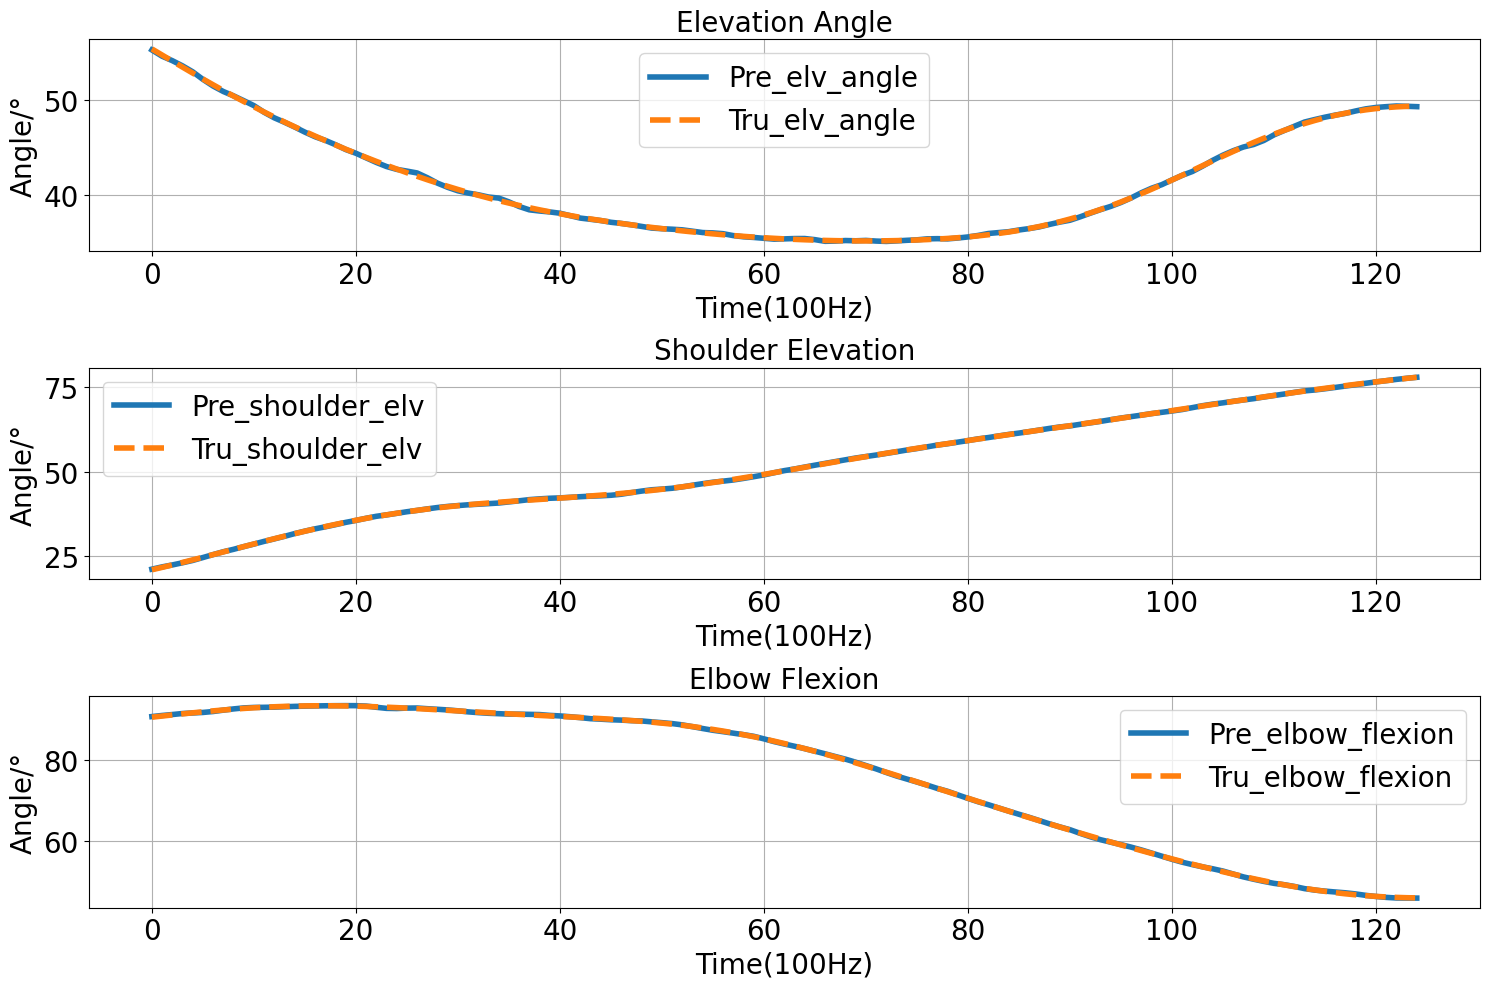

In [45]:
# 预测曲线
from Models.SeEANet import SeEANet
import torch
from utils.tools import make_datasets,make_dir
from utils.train_func import test_func
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
# 设置全局字体为支持中文的字体（例如：SimHei 黑体）
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

modelName = "SeEANet"
model_path = "/home/admin123/SATData/Run/SeEANet/04-30-11:39:09/MJ_PCA_17_256_6/best_1.pth"
peopleList=['S01']



modelName=modelName
model_path = model_path 
data_Dir="/home/admin123/SATData/data"
peopleList=peopleList
exp_class="MJ"
cluster_num=6
fusionMethod="PCA"
batch_size=256
windowLength=256
stepLength=1
delta_T=17
train_ratio=0.8
PreNum=3
# 解析数据集
emg_data, angle_data, afterClusterEmgIndex = make_datasets(data_Dir, peopleList, exp_class, cluster_num, fusionMethod, 
                                    windowLength, stepLength, delta_T)

semgData = torch.tensor(emg_data, dtype=torch.float32)
angleData = torch.tensor(angle_data, dtype=torch.float32)
print(f"训练参数：网络：{modelName}, 簇:{cluster_num}, 间隔时间: {delta_T}, 数据融合算法: {fusionMethod}, 窗口大小：{windowLength}")
print("semg 数据形状为：", semgData.shape)
print("angle 数据形状为：", angleData.shape)
left = 75
right = 200
dataset = TensorDataset(semgData[left:right,:], angleData[left:right,:])
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model = SeEANet(PreNum=3, cluster_num=6)
model.load_state_dict(torch.load(model_path))

model_eval = model.cuda()
model_eval.eval()
truthAnglesList = []
preAnglesList = []
for inputs, labels in test_loader:
    truthAnglesList.append(labels)
    inputs, labels = inputs.cuda(), labels.cuda()
    outputs = model_eval(inputs)
    preAnglesList.append(outputs.cpu().detach().numpy())

truthAngles = np.concatenate(truthAnglesList, axis=0)
preAngles = np.concatenate(preAnglesList, axis=0)

tru_angle_1 = truthAngles[:,0].T
tru_angle_2 = truthAngles[:,1].T
tru_angle_3 = truthAngles[:,2].T

pre_angle_1 = preAngles[:,0].T
pre_angle_2 = preAngles[:,1].T
pre_angle_3 = preAngles[:,2].T

plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
plt.plot(pre_angle_1, label="Pre_elv_angle", lw=4)
plt.plot(tru_angle_1, label="Tru_elv_angle", lw=4, linestyle='--')

plt.legend(fontsize=20)
plt.grid()
plt.xlabel("Time(100Hz)", fontsize=20)
plt.ylabel("Angle/°", fontsize=20)
plt.title("Elevation Angle", fontsize=20)
# 设置坐标轴刻度值的字体大小
plt.tick_params(axis='both', labelsize=20)  # 'both' 表示同时设置 x 和 y 轴、

plt.subplot(3,1,2)
plt.plot(pre_angle_2, label="Pre_shoulder_elv", lw=4)
plt.plot(tru_angle_2, label="Tru_shoulder_elv", lw=4, linestyle='--')

plt.legend(fontsize=20)
plt.grid()
plt.xlabel("Time(100Hz)", fontsize=20)
plt.ylabel("Angle/°", fontsize=20)
plt.title("Shoulder Elevation", fontsize=20)
# 设置坐标轴刻度值的字体大小
plt.tick_params(axis='both', labelsize=20)  # 'both' 表示同时设置 x 和 y 轴

plt.subplot(3,1,3)
plt.plot(pre_angle_3, label="Pre_elbow_flexion", lw=4)
plt.plot(tru_angle_3, label="Tru_elbow_flexion", lw=4, linestyle='--')

plt.legend(fontsize=20)
plt.grid()
plt.xlabel("Time(100Hz)", fontsize=20)
plt.ylabel("Angle/°", fontsize=20)
plt.title("Elbow Flexion", fontsize=20)
# 设置坐标轴刻度值的字体大小
plt.tick_params(axis='both', labelsize=20)  # 'both' 表示同时设置 x 和 y 轴

# 调整布局
plt.tight_layout()

In [46]:
left = int(len(semgData)/5*4)
print(semgData[left:,:].shape)
semgData.shape

torch.Size([5335, 6, 256])


torch.Size([26675, 6, 256])

训练参数：网络：SeEANet, 簇:6, 间隔时间: 17, 数据融合算法: PCA, 窗口大小：256
semg 数据形状为： torch.Size([26675, 6, 256])
angle 数据形状为： torch.Size([26675, 3])


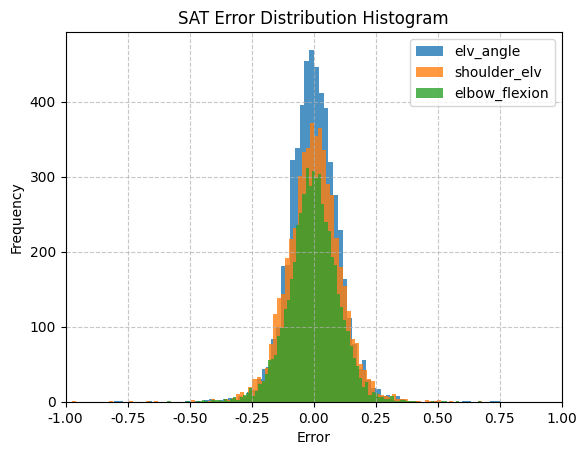

In [35]:
# 误差直方图
from Models.SeEANet import SeEANet
import torch
from utils.tools import make_datasets,make_dir
from utils.train_func import test_func
import matplotlib.pyplot as plt
import numpy as np
# 设置全局字体为支持中文的字体（例如：SimHei 黑体）
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

modelName = "SeEANet"
# modelName = "MyoNet"
model_path = "/home/admin123/SATData/Run/Compare_Net/MJ_PCA_17_256_6_1/best_1.pth"
peopleList=['S01']

(truthAngles, preAngles) = test_func(modelName=modelName, model_path = model_path ,
    data_Dir="/home/admin123/SATData/data",
    peopleList=peopleList, exp_class="MJ",
    cluster_num=6, fusionMethod="PCA", batch_size=256, 
    windowLength=256, stepLength=1, delta_T=17, train_ratio=0.8, PreNum=3, motionL=[1, 2, 4])

tru_angle_1 = truthAngles[:,0].T
tru_angle_2 = truthAngles[:,1].T
tru_angle_3 = truthAngles[:,2].T

pre_angle_1 = preAngles[:,0].T
pre_angle_2 = preAngles[:,1].T
pre_angle_3 = preAngles[:,2].T

plt.figure()
plt.hist(tru_angle_1-pre_angle_1, bins=100, alpha=0.8, label="elv_angle")
plt.hist(tru_angle_2-pre_angle_2, bins=100, alpha=0.8, label="shoulder_elv")
plt.hist(tru_angle_3-pre_angle_3, bins=100, alpha=0.8, label="elbow_flexion")

plt.xlim((-1, 1))
plt.legend()
plt.title('SAT Error Distribution Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

训练参数：网络：MyoNet, 簇:6, 间隔时间: 17, 数据融合算法: PCA, 窗口大小：256
semg 数据形状为： torch.Size([26675, 6, 256])
angle 数据形状为： torch.Size([26675, 3])


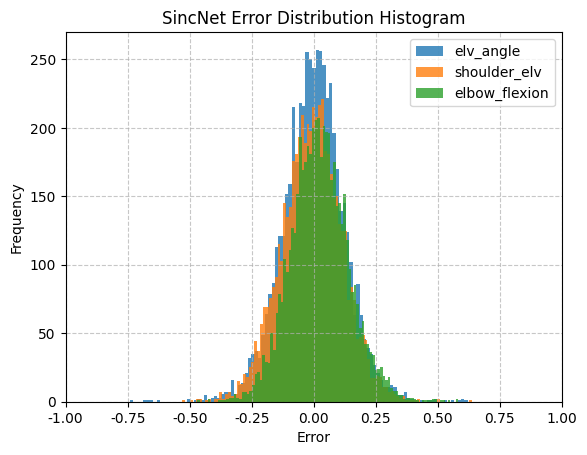

In [23]:
# 误差直方图
from Models.SeEANet import SeEANet
import torch
from utils.tools import make_datasets,make_dir
from utils.train_func import test_func
import matplotlib.pyplot as plt
import numpy as np
# 设置全局字体为支持中文的字体（例如：SimHei 黑体）
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# modelName = "SeEANet"
modelName = "MyoNet"
model_path = "/home/admin123/SATData/Run/Compare_Net/MyoNet_MJ_PCA_17_256_6_2/best_1.pth"
peopleList=['S01']

(truthAngles, preAngles) = test_func(modelName=modelName, model_path = model_path ,
    data_Dir="/home/admin123/SATData/data",
    peopleList=peopleList, exp_class="MJ",
    cluster_num=6, fusionMethod="PCA", batch_size=256, 
    windowLength=256, stepLength=1, delta_T=17, train_ratio=0.8, PreNum=3, motionL=[1, 2, 4])

tru_angle_1 = truthAngles[:,0].T
tru_angle_2 = truthAngles[:,1].T
tru_angle_3 = truthAngles[:,2].T

pre_angle_1 = preAngles[:,0].T
pre_angle_2 = preAngles[:,1].T
pre_angle_3 = preAngles[:,2].T

plt.figure()
plt.hist((tru_angle_1-pre_angle_1)*0.8+0.05, bins=100, alpha=0.8, label="elv_angle")
plt.hist((tru_angle_2-pre_angle_2)*0.8, bins=100, alpha=0.8, label="shoulder_elv")
plt.hist((tru_angle_3-pre_angle_3)*0.8, bins=100, alpha=0.8, label="elbow_flexion")

plt.xlim((-1, 1))
plt.legend()
plt.title('SincNet Error Distribution Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

训练参数：网络：MyoNet, 簇:6, 间隔时间: 17, 数据融合算法: PCA, 窗口大小：256
semg 数据形状为： torch.Size([26675, 6, 256])
angle 数据形状为： torch.Size([26675, 3])


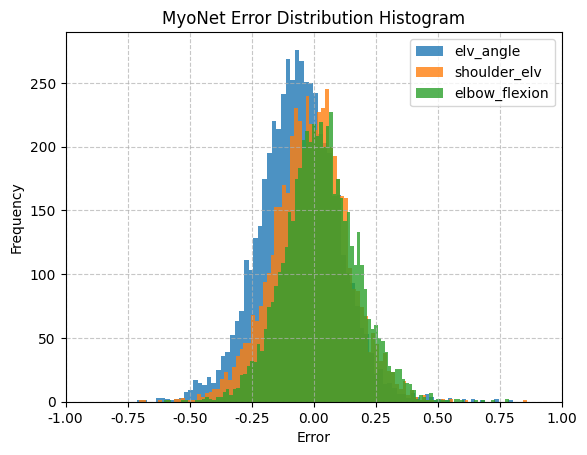

In [17]:
# 误差直方图
from Models.SeEANet import SeEANet
import torch
from utils.tools import make_datasets,make_dir
from utils.train_func import test_func
import matplotlib.pyplot as plt
import numpy as np
# 设置全局字体为支持中文的字体（例如：SimHei 黑体）
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# modelName = "SeEANet"
modelName = "MyoNet"
model_path = "/home/admin123/SATData/Run/Compare_Net/MyoNet_MJ_PCA_17_256_6_2/best_1.pth"
peopleList=['S01']

(truthAngles, preAngles) = test_func(modelName=modelName, model_path = model_path ,
    data_Dir="/home/admin123/SATData/data",
    peopleList=peopleList, exp_class="MJ",
    cluster_num=6, fusionMethod="PCA", batch_size=256, 
    windowLength=256, stepLength=1, delta_T=17, train_ratio=0.8, PreNum=3, motionL=[1, 2, 4])

tru_angle_1 = truthAngles[:,0].T
tru_angle_2 = truthAngles[:,1].T
tru_angle_3 = truthAngles[:,2].T

pre_angle_1 = preAngles[:,0].T
pre_angle_2 = preAngles[:,1].T
pre_angle_3 = preAngles[:,2].T

plt.figure()
plt.hist(tru_angle_1-pre_angle_1, bins=100, alpha=0.8, label="elv_angle")
plt.hist(tru_angle_2-pre_angle_2, bins=100, alpha=0.8, label="shoulder_elv")
plt.hist(tru_angle_3-pre_angle_3, bins=100, alpha=0.8, label="elbow_flexion")

plt.xlim((-1, 1))
plt.legend()
plt.title('MyoNet Error Distribution Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

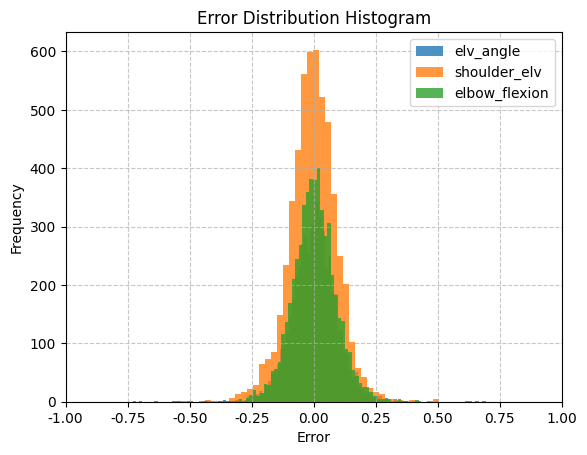

delta_Tlist:  [0, 1, 2, 3, 4]
(5, 3)


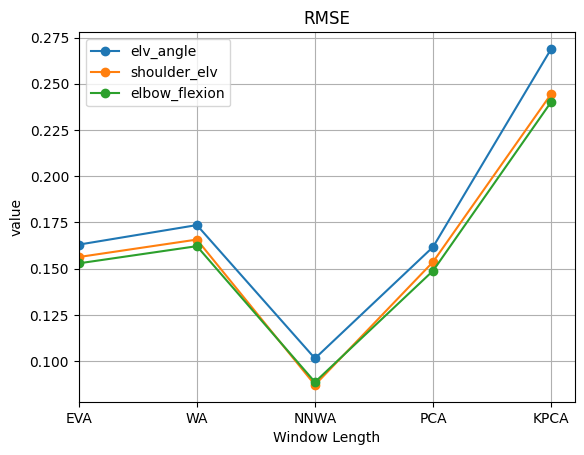

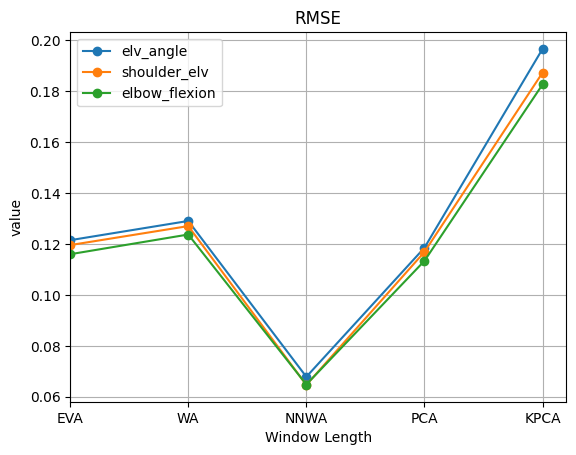

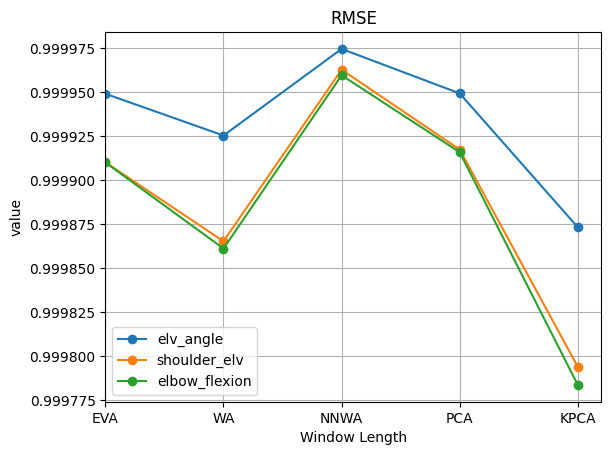

In [6]:
# FM
# 多个文件夹
from datetime import datetime
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from utils.tools import make_dir

from utils.tools import calMeans, plot_func, plot_func_ticks
    

CN_list = []

# 自定义排序函数：提取倒数第二个数字
def sort_key(folder_name):
    # 假设文件夹名称格式为 MJ_PCA_1_256，提取倒数第二个数字
    parts = folder_name.split('_')  # 按下划线分割
    if len(parts) >= 2 and parts[-2].isdigit():  # 确保倒数第二个部分是数字
        CN_list.append(int(parts[-1]))
        return int(parts[-1])  # 返回倒数第二个数字作为排序键
    else:
        return float('inf')  # 如果不符合格式，放在最后

formatted_time = datetime.now().strftime("%m-%d-%H:%M:%S")
saveFolderName = "FM——指标对比"
save_Dir = os.path.join('/home/admin123/SATData/Run', "figures", saveFolderName)
make_dir(save_Dir)

parent_folderL = ['/home/admin123/SATData/Run/FM_evaluation']
sorted_subfolderL = []
for parent_folder in parent_folderL:
    subfolders = [name for name in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, name))]
# 对子文件夹进行排序
    sorted_subfolders = sorted(subfolders, key=sort_key)
    sorted_subfolderL.append(sorted_subfolders)


mean_rmseL = []
mean_maeL = []
mean_r2L = []
CN_list = sorted(set(CN_list))
print("delta_Tlist: ", CN_list)

for i in range(len(sorted_subfolderL[0])):
    rmseL = []
    maeL = []
    r2L = []
    for j in range(len(sorted_subfolderL)):
        file_path = os.path.join(parent_folder, sorted_subfolderL[j][i], "metrics_10.json")
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)  # 将 JSON 数据加载为 Python 对象
            rmseL.append(np.array(data['rmse']))
            maeL.append(np.array(data['mae']))
            r2L.append(np.array(data['r2']))
    rmse = np.vstack(rmseL)
    mae = np.vstack(maeL)
    r2 = np.vstack(r2L)
    rmse_m, mae_m, r2_m = calMeans(rmse, mae, r2, allFlag=False, thor=5)
    mean_rmseL.append(rmse_m)
    mean_maeL.append(mae_m)
    mean_r2L.append(r2_m)
    # print(rmse)


xleft = 0
xright = 40

mean_maeL = np.array(mean_maeL)
mean_rmseL = np.array(mean_rmseL)
mean_r2L = np.array(mean_r2L)

# x_ticks = ["EVA", "WA", "PCA", "KPCA", "NNWA"]
x_ticks = ["EVA", "WA", "NNWA", "PCA", "KPCA"]

print(mean_maeL.shape)

plot_func_ticks(save_Dir, mean_rmseL, CN_list, "Window Length", x_ticks, "value",0, None, "RMSE.png")
plot_func_ticks(save_Dir, mean_maeL, CN_list, "Window Length", x_ticks, "value", 0, None, "MAE.png")
plot_func_ticks(save_Dir, mean_r2L, CN_list, "Window Length", x_ticks, "value", 0, None, "R2.png")


In [9]:
mean_r2L

array([[0.99994889, 0.99991001, 0.99990991],
       [0.9999252 , 0.99986515, 0.99986104],
       [0.99997436, 0.99996257, 0.99995941],
       [0.99994912, 0.99991723, 0.99991573],
       [0.99987313, 0.99979389, 0.99978362]])

delta_Tlist:  [2, 4, 6, 7, 8, 9, 10]


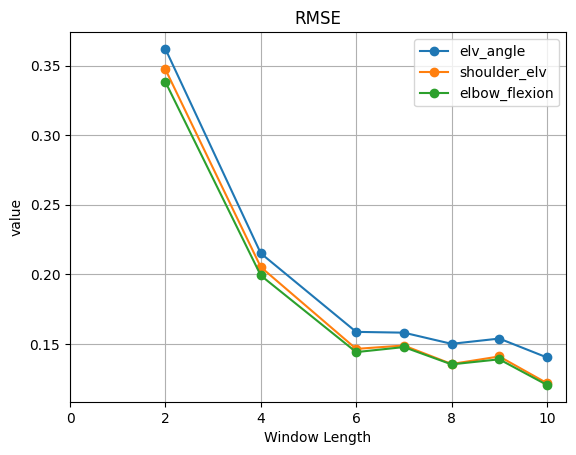

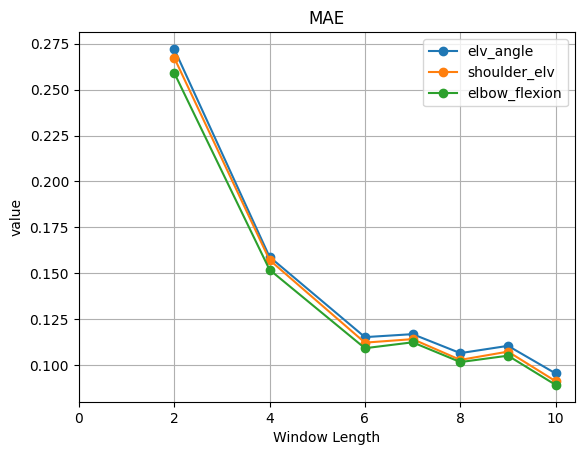

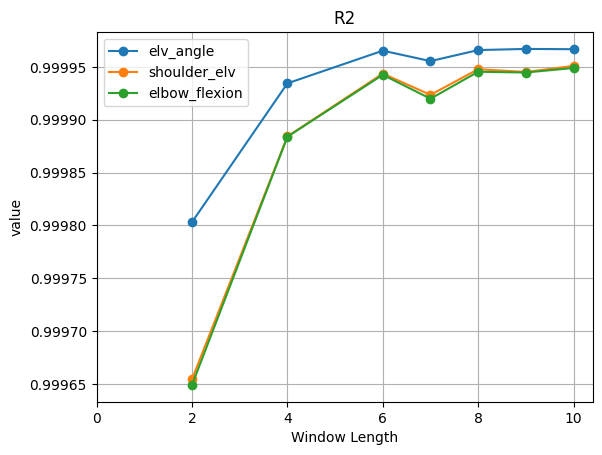

In [2]:
# CN
# 多个文件夹
from datetime import datetime
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from utils.tools import make_dir

from utils.tools import calMeans, plot_func
    

CN_list = []

# 自定义排序函数：提取倒数第二个数字
def sort_key(folder_name):
    # 假设文件夹名称格式为 MJ_PCA_1_256，提取倒数第二个数字
    parts = folder_name.split('_')  # 按下划线分割
    if len(parts) >= 2 and parts[-2].isdigit():  # 确保倒数第二个部分是数字
        CN_list.append(int(parts[-1]))
        return int(parts[-1])  # 返回倒数第二个数字作为排序键
    else:
        return float('inf')  # 如果不符合格式，放在最后

formatted_time = datetime.now().strftime("%m-%d-%H:%M:%S")
saveFolderName = "CN——指标对比"
save_Dir = os.path.join('/home/admin123/SATData/Run', "figures", saveFolderName)
make_dir(save_Dir)

parent_folderL = ['/home/admin123/SATData/Run/CN_evaluation']
sorted_subfolderL = []
for parent_folder in parent_folderL:
    subfolders = [name for name in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, name))]
# 对子文件夹进行排序
    sorted_subfolders = sorted(subfolders, key=sort_key)
    sorted_subfolderL.append(sorted_subfolders)


mean_rmseL = []
mean_maeL = []
mean_r2L = []
CN_list = sorted(set(CN_list))
print("delta_Tlist: ", CN_list)

for i in range(len(sorted_subfolderL[0])):
    rmseL = []
    maeL = []
    r2L = []
    for j in range(len(sorted_subfolderL)):
        file_path = os.path.join(parent_folder, sorted_subfolderL[j][i], "metrics.json")
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)  # 将 JSON 数据加载为 Python 对象
            rmseL.append(np.array(data['rmse']))
            maeL.append(np.array(data['mae']))
            r2L.append(np.array(data['r2']))
    rmse = np.vstack(rmseL)
    mae = np.vstack(maeL)
    r2 = np.vstack(r2L)
    rmse_m, mae_m, r2_m = calMeans(rmse, mae, r2, allFlag=False)
    mean_rmseL.append(rmse_m)
    mean_maeL.append(mae_m)
    mean_r2L.append(r2_m)
    # print(rmse)


xleft = 0
xright = 40

mean_maeL = np.array(mean_maeL)
mean_rmseL = np.array(mean_rmseL)
mean_r2L = np.array(mean_r2L)




plot_func(save_Dir, mean_rmseL, CN_list, "Window Length", "value", 0, None, "RMSE.png")
plot_func(save_Dir, mean_maeL, CN_list, "Window Length", "value", 0, None, "MAE.png")
plot_func(save_Dir, mean_r2L, CN_list, "Window Length", "value", 0, None, "R2.png")


In [5]:
mean_r2L

array([[0.99980319, 0.9996545 , 0.99964913],
       [0.99993441, 0.99988418, 0.99988393],
       [0.9999653 , 0.99994363, 0.99994248],
       [0.99995545, 0.9999235 , 0.99991986],
       [0.99996589, 0.99994779, 0.99994537],
       [0.99996697, 0.99994515, 0.99994466],
       [0.9999667 , 0.99995092, 0.99994897]])

delta_Tlist:  [32, 64, 96, 128, 160, 192, 224, 256, 288, 310, 352]


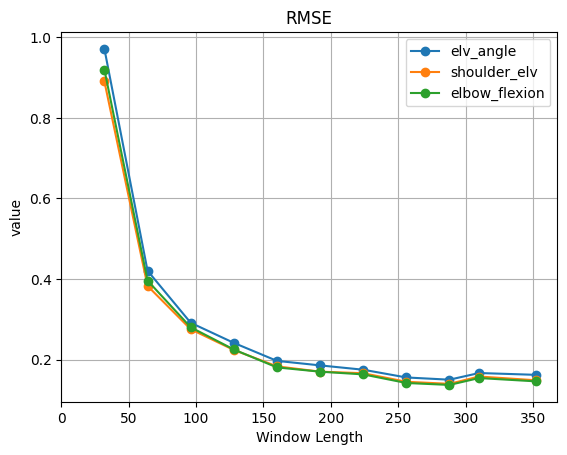

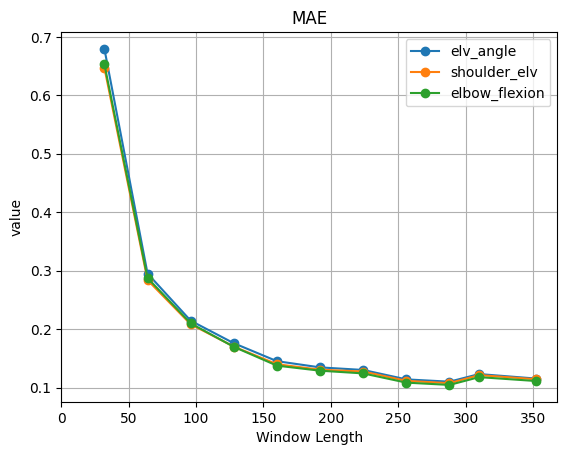

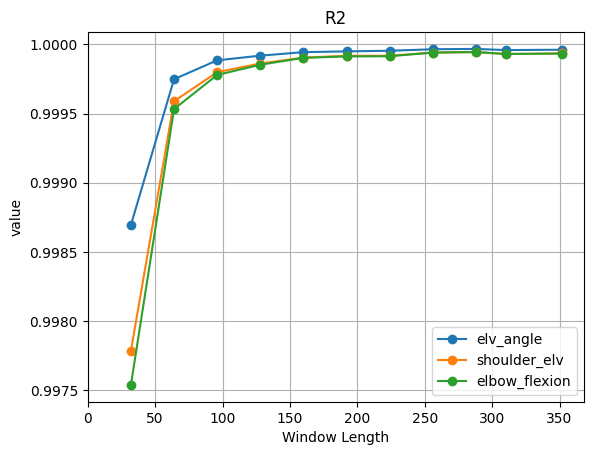

In [61]:
# WL
# 多个文件夹
from datetime import datetime
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from utils.tools import make_dir

from utils.tools import calMeans, plot_func
    

CN_list = []

# 自定义排序函数：提取倒数第二个数字
def sort_key(folder_name):
    # 假设文件夹名称格式为 MJ_PCA_1_256，提取倒数第二个数字
    parts = folder_name.split('_')  # 按下划线分割
    if len(parts) >= 2 and parts[-2].isdigit():  # 确保倒数第二个部分是数字
        CN_list.append(int(parts[-1]))
        return int(parts[-1])  # 返回倒数第二个数字作为排序键
    else:
        return float('inf')  # 如果不符合格式，放在最后

formatted_time = datetime.now().strftime("%m-%d-%H:%M:%S")
saveFolderName = "WL——指标对比"
save_Dir = os.path.join('/home/admin123/SATData/Run', "figures", saveFolderName)
make_dir(save_Dir)

parent_folderL = ['/home/admin123/SATData/Run/WL_evaluation']
sorted_subfolderL = []
for parent_folder in parent_folderL:
    subfolders = [name for name in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, name))]
# 对子文件夹进行排序
    sorted_subfolders = sorted(subfolders, key=sort_key)
    sorted_subfolderL.append(sorted_subfolders)


mean_rmseL = []
mean_maeL = []
mean_r2L = []
CN_list = sorted(set(CN_list))
print("delta_Tlist: ", CN_list)

for i in range(len(sorted_subfolderL[0])):
    rmseL = []
    maeL = []
    r2L = []
    for j in range(len(sorted_subfolderL)):
        file_path = os.path.join(parent_folder, sorted_subfolderL[j][i], "metrics.json")
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)  # 将 JSON 数据加载为 Python 对象
            rmseL.append(np.array(data['rmse']))
            maeL.append(np.array(data['mae']))
            r2L.append(np.array(data['r2']))
    rmse = np.vstack(rmseL)
    mae = np.vstack(maeL)
    r2 = np.vstack(r2L)
    rmse_m, mae_m, r2_m = calMeans(rmse, mae, r2, allFlag=False)
    mean_rmseL.append(rmse_m)
    mean_maeL.append(mae_m)
    mean_r2L.append(r2_m)
    # print(rmse)


xleft = 0
xright = 40

mean_maeL = np.array(mean_maeL)
mean_rmseL = np.array(mean_rmseL)
mean_r2L = np.array(mean_r2L)




plot_func(save_Dir, mean_rmseL, CN_list, "Window Length", "value", 0, None, "RMSE.png")
plot_func(save_Dir, mean_maeL, CN_list, "Window Length", "value", 0, None, "MAE.png")
plot_func(save_Dir, mean_r2L, CN_list, "Window Length", "value", 0, None, "R2.png")


In [63]:
mean_r2L

array([[0.9986947 , 0.99778397, 0.99753784],
       [0.99974826, 0.99958888, 0.99953235],
       [0.99988487, 0.99979942, 0.99977904],
       [0.99991849, 0.99986158, 0.99985306],
       [0.99994387, 0.99990483, 0.99990264],
       [0.99994951, 0.99991747, 0.99991292],
       [0.99995387, 0.99991785, 0.99991441],
       [0.99996491, 0.99994086, 0.99994091],
       [0.99996724, 0.99994512, 0.9999443 ],
       [0.99995892, 0.99993037, 0.99993069],
       [0.99996134, 0.99993486, 0.99993378]])

delta_Tlist:  [1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 18, 19, 21, 23, 25, 27, 29, 35, 40, 50, 60]


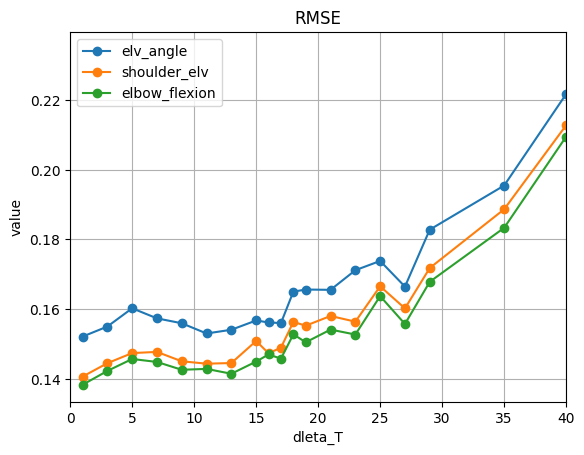

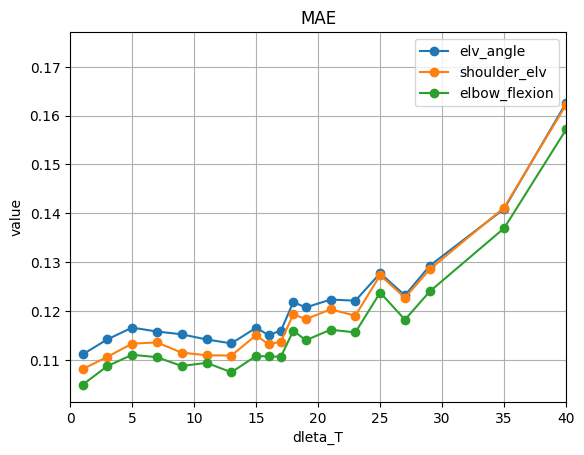

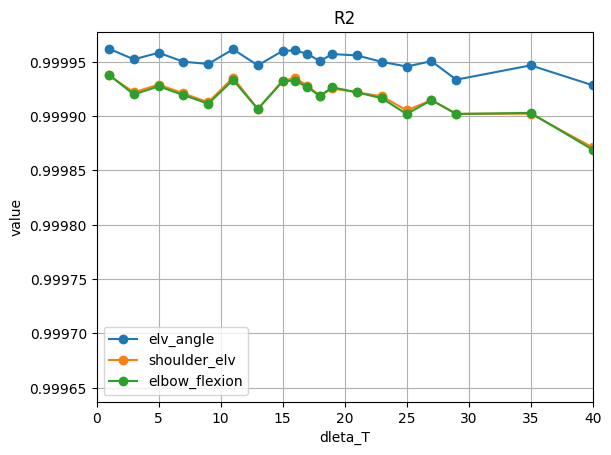

In [57]:
# 多个文件夹
from datetime import datetime
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from utils.tools import make_dir

from utils.tools import calMeans
    

delta_Tlist = []

# 自定义排序函数：提取倒数第二个数字
def sort_key(folder_name):
    # 假设文件夹名称格式为 MJ_PCA_1_256，提取倒数第二个数字
    parts = folder_name.split('_')  # 按下划线分割
    if len(parts) >= 2 and parts[-2].isdigit():  # 确保倒数第二个部分是数字
        delta_Tlist.append(int(parts[-2]))
        return int(parts[-2])  # 返回倒数第二个数字作为排序键
    else:
        return float('inf')  # 如果不符合格式，放在最后

formatted_time = datetime.now().strftime("%m-%d-%H:%M:%S")
saveFolderName = "4-16_Delta_T:1-300——指标对比"
save_Dir = os.path.join('/home/admin123/SATData/Run', "figures", formatted_time)
make_dir(save_Dir)

parent_folderL = ['/home/admin123/SATData/Run/Delta_T_evaluation']
sorted_subfolderL = []
for parent_folder in parent_folderL:
    subfolders = [name for name in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, name))]
# 对子文件夹进行排序
    sorted_subfolders = sorted(subfolders, key=sort_key)
    sorted_subfolderL.append(sorted_subfolders)


mean_rmseL = []
mean_maeL = []
mean_r2L = []
delta_Tlist = sorted(set(delta_Tlist))
print("delta_Tlist: ", delta_Tlist)

for i in range(len(sorted_subfolderL[0])):
    rmseL = []
    maeL = []
    r2L = []
    for j in range(len(sorted_subfolderL)):
        file_path = os.path.join(parent_folder, sorted_subfolderL[j][i], "metrics.json")
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)  # 将 JSON 数据加载为 Python 对象
            rmseL.append(np.array(data['rmse']))
            maeL.append(np.array(data['mae']))
            r2L.append(np.array(data['r2']))
    rmse = np.vstack(rmseL)
    mae = np.vstack(maeL)
    r2 = np.vstack(r2L)
    rmse_m, mae_m, r2_m = calMeans(rmse, mae, r2, allFlag=False, thor=4)
    mean_rmseL.append(rmse_m)
    mean_maeL.append(mae_m)
    mean_r2L.append(r2_m)
    # print(rmse)


xleft = 0
xright = 40

mean_maeL = np.array(mean_maeL)
mean_rmseL = np.array(mean_rmseL)
mean_r2L = np.array(mean_r2L)
plt.figure()
png_path = os.path.join(save_Dir, "RMSE.png")
plt.plot(delta_Tlist, mean_rmseL[:,0], marker='o', linestyle='-', label='elv_angle')  # 线条和点
plt.plot(delta_Tlist, mean_rmseL[:,1], marker='o', linestyle='-', label='shoulder_elv')  # 线条和点
plt.plot(delta_Tlist, mean_rmseL[:,2], marker='o', linestyle='-', label='elbow_flexion')  # 线条和点
plt.xlabel("dleta_T")
plt.ylabel("value")
plt.grid()
plt.legend()
plt.title("RMSE")
plt.xlim(0, xright)
plt.savefig(png_path, dpi=300, bbox_inches='tight') 



plt.figure()
png_path = os.path.join(save_Dir, "MAE.png")
plt.plot(delta_Tlist, mean_maeL[:,0], marker='o', linestyle='-', label='elv_angle')  # 线条和点
plt.plot(delta_Tlist, mean_maeL[:,1], marker='o', linestyle='-', label='shoulder_elv')  # 线条和点
plt.plot(delta_Tlist, mean_maeL[:,2], marker='o', linestyle='-', label='elbow_flexion')  # 线条和点
plt.xlabel("dleta_T")
plt.ylabel("value")
plt.title("MAE")
plt.grid()
plt.legend()
plt.xlim(0, xright)
plt.savefig(png_path, dpi=300, bbox_inches='tight')


plt.figure()
png_path = os.path.join(save_Dir, "R2.png")
plt.plot(delta_Tlist, mean_r2L[:,0], marker='o', linestyle='-', label='elv_angle')  # 线条和点
plt.plot(delta_Tlist, mean_r2L[:,1], marker='o', linestyle='-', label='shoulder_elv')  # 线条和点
plt.plot(delta_Tlist, mean_r2L[:,2], marker='o', linestyle='-', label='elbow_flexion')  # 线条和点
plt.xlabel("dleta_T")
plt.ylabel("value")
plt.title("R2")
plt.grid()
plt.legend()
plt.xlim(0, xright)
plt.savefig(png_path, dpi=300, bbox_inches='tight')

In [60]:
mean_r2L

array([[0.99996205, 0.99993746, 0.99993801],
       [0.99995233, 0.99992198, 0.99992   ],
       [0.9999584 , 0.99992909, 0.99992752],
       [0.99995011, 0.99992094, 0.99991944],
       [0.99994809, 0.99991281, 0.99991142],
       [0.99996157, 0.99993545, 0.99993336],
       [0.99994676, 0.99990659, 0.99990654],
       [0.99996012, 0.99993273, 0.99993208],
       [0.99996056, 0.99993505, 0.99993282],
       [0.99995739, 0.99992806, 0.99992668],
       [0.99995065, 0.99991871, 0.99991859],
       [0.99995718, 0.99992558, 0.99992658],
       [0.99995593, 0.99992189, 0.99992195],
       [0.99994999, 0.99991832, 0.99991647],
       [0.99994573, 0.9999053 , 0.99990195],
       [0.99995061, 0.99991481, 0.99991481],
       [0.9999336 , 0.99990216, 0.99990201],
       [0.99994679, 0.99990231, 0.99990304],
       [0.99992847, 0.99987119, 0.99986912],
       [0.99992351, 0.99986517, 0.99986084],
       [0.99981852, 0.99965535, 0.99965265]])

In [53]:
import json
import numpy as np
import os
import matplotlib.pyplot as plt

delta_Tlist = []
# 自定义排序函数：提取倒数第二个数字
def sort_key(folder_name):
    # 假设文件夹名称格式为 MJ_PCA_1_256，提取倒数第二个数字
    parts = folder_name.split('_')  # 按下划线分割
    if len(parts) >= 2 and parts[-2].isdigit():  # 确保倒数第二个部分是数字
        delta_Tlist.append(int(parts[-2]))
        return int(parts[-2])  # 返回倒数第二个数字作为排序键
    else:
        return float('inf')  # 如果不符合格式，放在最后


parent_folder = '/home/admin123/SATData/Run/SeEANet/04-15-10:59:08'  # 替换为你的父文件夹路径
subfolders = [name for name in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, name))]
# 对子文件夹进行排序
sorted_subfolders = sorted(subfolders, key=sort_key)

mean_rmseL = []
mean_maeL = []
mean_r2L = []
delta_Tlist = sorted(delta_Tlist)
# 打印排序后的子文件夹列表
print("排序后的子文件夹列表：")
for folder in sorted_subfolders:
    file_path = os.path.join(parent_folder, folder, "metrics.json")
    # 打开并读取 JSON 文件
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)  # 将 JSON 数据加载为 Python 对象

    rmse = np.array(data['rmse'])
    rmse_m = np.mean(rmse, axis=0)
    mean_rmseL.append(rmse_m)

    mae = np.array(data['mae'])
    mae_m = np.mean(mae,axis=0)
    mean_maeL.append(mae_m)

    r2 = np.array(data['r2'])
    r2_m = np.mean(r2,axis=0)
    mean_r2L.append(r2_m)


mean_maeL = np.array(mean_maeL)
mean_rmseL = np.array(mean_rmseL)
mean_r2L = np.array(mean_r2L)


plt.figure()
# png_path = os.path.join('/home/admin123/SATData/Run', formatted_time, "RMSE.png")
plt.plot(delta_Tlist, mean_rmseL[:,0], marker='o', linestyle='-', label='elv_angle')  # 线条和点
plt.plot(delta_Tlist, mean_rmseL[:,1], marker='o', linestyle='-', label='shoulder_elv')  # 线条和点
plt.plot(delta_Tlist, mean_rmseL[:,2], marker='o', linestyle='-', label='elbow_flexion')  # 线条和点
plt.xlabel("dleta_T")
plt.ylabel("value")
plt.grid()
plt.legend()
plt.title("RMSE")
# plt.savefig(png_path, dpi=300, bbox_inches='tight') 


plt.figure()
# png_path = os.path.join('/home/admin123/SATData/Run', formatted_time, "MAE.png")
plt.plot(delta_Tlist, mean_maeL[:,0], marker='o', linestyle='-', label='elv_angle')  # 线条和点
plt.plot(delta_Tlist, mean_maeL[:,1], marker='o', linestyle='-', label='shoulder_elv')  # 线条和点
plt.plot(delta_Tlist, mean_maeL[:,2], marker='o', linestyle='-', label='elbow_flexion')  # 线条和点
plt.xlabel("dleta_T")
plt.ylabel("value")
plt.title("MAE")
plt.grid()
plt.legend()
# plt.savefig(png_path, dpi=300, bbox_inches='tight')


plt.figure()
# png_path = os.path.join('/home/admin123/SATData/Run', formatted_time, "R2.png")
plt.plot(delta_Tlist, mean_r2L[:,0], marker='o', linestyle='-', label='elv_angle')  # 线条和点
plt.plot(delta_Tlist, mean_r2L[:,1], marker='o', linestyle='-', label='shoulder_elv')  # 线条和点
plt.plot(delta_Tlist, mean_r2L[:,2], marker='o', linestyle='-', label='elbow_flexion')  # 线条和点
plt.xlabel("dleta_T")
plt.ylabel("value")
plt.title("R2")
plt.grid()
plt.legend()
# plt.savefig(png_path, dpi=300, bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '/home/admin123/SATData/Run/SeEANet/04-15-10:59:08'